# Data Curation
This notebook showcases the building blocks that can be used for building a simple data curation pipeline using [NeMo Curator](https://github.com/NVIDIA/NeMo-Curator).

## Reading Materials
Before proceeding, we highly recommend looking through the following deep dive blog posts that walk you through building data curation pipelines using NeMo Curator:
- [Curating Custom Datasets for LLM Training with NVIDIA NeMo Curator](https://developer.nvidia.com/blog/curating-custom-datasets-for-llm-training-with-nvidia-nemo-curator/)
- [Curating Custom Datasets for LLM Parameter-Efficient Fine-Tuning with NVIDIA NeMo Curator](https://developer.nvidia.com/blog/curating-custom-datasets-for-llm-parameter-efficient-fine-tuning-with-nvidia-nemo-curator/)

Also, please checkout [our tutorials](https://github.com/NVIDIA/NeMo-Curator/tree/main/tutorials) in the repository to learn more about various functionalities that NeMo Curator provides.

In this notebook, we will use the [Law-StackExchange dataset](https://huggingface.co/datasets/ymoslem/Law-StackExchange) for this pipeline, which is a dataset of legal question/answers scraped from the Stack Exchange website. This notebook is the summarized version of our existing [synthetic data generation tutorial](https://github.com/NVIDIA/NeMo-Curator/tree/main/tutorials/peft-curation-with-sdg). Feel free to go through that tutorial to gain a better understanding of various NeMo Curator facilities.

## Setup and Requirements
The NeMo dependencies are already installed in the container. However, before proceeding you need to install one dependency to follow along. Execute the following cell before getting started.

# Dataset exploration  
Before starting to actually work with the dataset, we will explore the overall properties of the training dataset to gain some insights 

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

In [25]:
# Load the JSON file into a DataFrame
file_path = 'data/law-stackexchange-questions-answers.json'  # Upload the dataset to the data/ folder in advance
train_dataset_df = pd.read_json(file_path, orient='records')
train_dataset_df.head()

,question_id,tags,score,license,link,question_title,question_body,answers
0,94665,"[criminal-law, driving, sentencing]",23,CC BY-SA 4.0,https://law.stackexchange.com/questions/94665/...,Why is drunk driving causing accident punished...,<p>When people drink and drive and then cause ...,"[{'answer_id': 94666, 'score': 72, 'body': '<h..."
1,94671,"[contract-law, legal-terms, consideration]",0,CC BY-SA 4.0,https://law.stackexchange.com/questions/94671/...,What counts as consideration in contract law?,<p>What counts as consideration in contract la...,"[{'answer_id': 94672, 'score': 1, 'body': '<p>..."
2,94683,"[employment, california, teenager]",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/94683/...,Question Concerning Responding to Employer of ...,<p>My high school daughter worked for about a ...,"[{'answer_id': 94687, 'score': 3, 'body': '<h2..."
3,67110,"[united-states, constitutional-law, federalism]",2,CC BY-SA 4.0,https://law.stackexchange.com/questions/67110/...,Can Hawaii secede from the U.S. through legal ...,<p>Can Hawaii secede from the U.S. through leg...,"[{'answer_id': 67111, 'score': 9, 'body': '<p>..."
4,94678,"[united-kingdom, property, any-jurisdiction, l...",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/94678/...,Legality of privately bibby Stockholming to sa...,<p>It seems that the principal impetus of movi...,"[{'answer_id': 94712, 'score': 1, 'body': '<p>..."


In [27]:
train_dataset_df['quest_len'] = [len(x) for x in train_dataset_df['question_body']]
train_dataset_df['tag_n'] = train_dataset_df['tags'].apply(lambda x: len(x) )
train_dataset_df.head()

,question_id,tags,score,license,link,question_title,question_body,answers,quest_len,tag_n
0,94665,"[criminal-law, driving, sentencing]",23,CC BY-SA 4.0,https://law.stackexchange.com/questions/94665/...,Why is drunk driving causing accident punished...,<p>When people drink and drive and then cause ...,"[{'answer_id': 94666, 'score': 72, 'body': '<h...",356,3
1,94671,"[contract-law, legal-terms, consideration]",0,CC BY-SA 4.0,https://law.stackexchange.com/questions/94671/...,What counts as consideration in contract law?,<p>What counts as consideration in contract la...,"[{'answer_id': 94672, 'score': 1, 'body': '<p>...",127,3
2,94683,"[employment, california, teenager]",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/94683/...,Question Concerning Responding to Employer of ...,<p>My high school daughter worked for about a ...,"[{'answer_id': 94687, 'score': 3, 'body': '<h2...",1914,3
3,67110,"[united-states, constitutional-law, federalism]",2,CC BY-SA 4.0,https://law.stackexchange.com/questions/67110/...,Can Hawaii secede from the U.S. through legal ...,<p>Can Hawaii secede from the U.S. through leg...,"[{'answer_id': 67111, 'score': 9, 'body': '<p>...",274,3
4,94678,"[united-kingdom, property, any-jurisdiction, l...",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/94678/...,Legality of privately bibby Stockholming to sa...,<p>It seems that the principal impetus of movi...,"[{'answer_id': 94712, 'score': 1, 'body': '<p>...",620,5


In [28]:
train_dataset_df = train_dataset_df[train_dataset_df['quest_len'] < 1600]
train_dataset_df

,question_id,tags,score,license,link,question_title,question_body,answers,quest_len,tag_n
0,94665,"[criminal-law, driving, sentencing]",23,CC BY-SA 4.0,https://law.stackexchange.com/questions/94665/...,Why is drunk driving causing accident punished...,<p>When people drink and drive and then cause ...,"[{'answer_id': 94666, 'score': 72, 'body': '<h...",356,3
1,94671,"[contract-law, legal-terms, consideration]",0,CC BY-SA 4.0,https://law.stackexchange.com/questions/94671/...,What counts as consideration in contract law?,<p>What counts as consideration in contract la...,"[{'answer_id': 94672, 'score': 1, 'body': '<p>...",127,3
3,67110,"[united-states, constitutional-law, federalism]",2,CC BY-SA 4.0,https://law.stackexchange.com/questions/67110/...,Can Hawaii secede from the U.S. through legal ...,<p>Can Hawaii secede from the U.S. through leg...,"[{'answer_id': 67111, 'score': 9, 'body': '<p>...",274,3
4,94678,"[united-kingdom, property, any-jurisdiction, l...",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/94678/...,Legality of privately bibby Stockholming to sa...,<p>It seems that the principal impetus of movi...,"[{'answer_id': 94712, 'score': 1, 'body': '<p>...",620,5
6,30604,"[united-states, corporate-law, minor, incorpor...",1,CC BY-SA 4.0,https://law.stackexchange.com/questions/30604/...,What role does the person who signs post incor...,<p>I am a minor and my mother would be signing...,"[{'answer_id': 30616, 'score': 2, 'body': '<p>...",340,4
...,...,...,...,...,...,...,...,...,...,...
24365,99,"[indian-penal-code, india]",6,CC BY-SA 3.0,https://law.stackexchange.com/questions/99/rep...,Representing your own case,<p>Are there any prerequisites to represent on...,"[{'answer_id': 122, 'score': 2, 'body': '<p>Le...",137,2
24366,74,"[united-states, search-and-seizure, fourth-ame...",10,CC BY-SA 3.0,https://law.stackexchange.com/questions/74/wha...,What rights do foreigners have when the CBP wa...,"<p>Since <a href=""https://www.aclu.org/governm...","[{'answer_id': 75, 'score': 5, 'body': '<p>For...",1189,3
24367,26,"[united-kingdom, police]",25,CC BY-SA 3.0,https://law.stackexchange.com/questions/26/und...,Under what circumstances am I obliged to show ...,"<p>In the UK, if a police constable stops you ...","[{'answer_id': 80, 'score': 16, 'body': '<p>Pe...",388,2
24368,13,"[criminal-law, united-states]",9,CC BY-SA 3.0,https://law.stackexchange.com/questions/13/is-...,Is there any way to bring a criminal case befo...,<p>Is there any way to present a case to the g...,"[{'answer_id': 33, 'score': 6, 'body': '<p>To ...",113,2


## Now let's see if there is a relationship between the length of the question and the number of the tags

In [18]:
stdev_quest_len_tags

array([ 786.54744029,  785.48739901,  822.35071599,  864.43194123,
       1024.36575414])

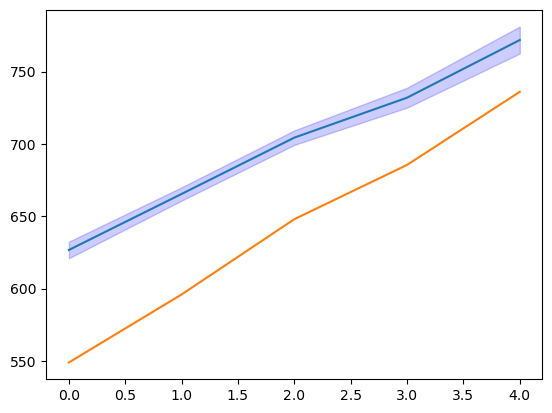

In [32]:
# Get the mean values of the number of tags
mean_quest_len_tags =  np.array([np.mean(train_dataset_df[train_dataset_df['tag_n'] == tn]["quest_len"]) for tn in np.arange(1,6)])
median_quest_len_tags = np.array([np.median(train_dataset_df[train_dataset_df['tag_n'] == tn]["quest_len"]) for tn in np.arange(1,6)])
stdev_quest_len_tags =  np.array([sem(train_dataset_df[train_dataset_df['tag_n'] == tn]["quest_len"]) for tn in np.arange(1,6)])
# Plotting
fig, ax = plt.subplots()
ax.plot(mean_quest_len_tags)
# shade standard deviation around the mean
ax.fill_between(np.arange(5), mean_quest_len_tags - stdev_quest_len_tags, mean_quest_len_tags + stdev_quest_len_tags, color='b', alpha=0.2)
ax.plot(median_quest_len_tags)


Indeed, there is a very striking relationship between them, now let's find a linear function for this:

In [ ]:
slope_tag, intercept = np.polyfit(np.arange(1,6), median_quest_len_tags, 1)
x_value = (y_value - intercept) / slope

In [ ]:
! pip install ipywidgets

---
## Getting Started

To get started, let's setup some environment variables, as well as path variables that will be used for storing the curated data, as well as intermediate temporary files that are required for this notebooks to function.

In [ ]:
import os
os.environ["DASK_DATAFRAME__QUERY_PLANNING"] = "False"  # Needed for running Curator on the GPU

NOTEBOOK_DIR = os.path.abspath("")
DATA_DIR = os.path.join(NOTEBOOK_DIR, "data")
TEMP_DIR = os.path.join(NOTEBOOK_DIR, ".temp")
os.makedirs(DATA_DIR, exist_ok=True)

Let's now import everything we need to build our data curation pipeline. For your conveniene, we've provided the document builder implementations that allow you to download the dataset from HuggingFace and convert it into a Pandas `DataFrame`.

We have additionally implemented a score-based filter that allows you to filter the dataset rows using the score values assigned to each question. You can use this implementation as the basis for creating your own filtering/scoring mechanisms using NeMo Curator.

In [ ]:
from nemo_curator.utils.distributed_utils import get_client
from nemo_curator.datasets import DocumentDataset
from nemo_curator.filters import WordCountFilter
from nemo_curator.modifiers import UnicodeReformatter
from nemo_curator.utils.file_utils import expand_outdir_and_mkdir
from nemo_curator import ScoreFilter, Sequential
from nemo_curator.modules.modify import Modify

# Importing helper functions
from helpers.filters import FilterLowScores
from helpers.docbuilder import download_and_convert_dataset

Before proceeding, let's decide the compute resources we'd like to use for running our data curation pipeline. NeMo Curator uses Dask to orchestrate scalable data processing. As such, it needs to know what resources to use. 

For the purposes of this notebook, we will instruct NeMo Curator to use 8 CPU workers. While most NeMo Curator functionalities can be executed on the CPU, some modules (such as semantic deduplication) can only be executed on the GPU. Please make sure to select the appropriate device.

Note that you can increase or decrease the number of CPU workers depending on the runtime environment. Keep in mind that each CPU worker gets allocated a fixed amount of the total available system memory (RAM). Thus, if the environment does not have enough memory available, Dask operations might fail.

Once we have decided on the resources to use, we can initialize our Dask cluster and start using NeMo Curator.

In [ ]:
device = "cpu"  # It can be either "cpu" or "gpu"
n_workers = 4  # Number of workers to use for Dask. If running out of memory, try reducing this.
client = get_client(device, n_workers=n_workers, set_torch_to_use_rmm=False)

---
## The Main Data Curation and Processing Pipeline

We start by downloading and converting the dataset into a suitable format. This is done via the document builders that we have provided for you.

In [ ]:
dataset_df = download_and_convert_dataset(DATA_DIR)
raw_dataset = DocumentDataset.from_pandas(dataset_df)

Next, we need to define our data curation pipeline. The pipeline we define here is very simple, as it contains basic filtering operations

> NOTE: to use the modules that need a GPU, the dataset has to be converted to the `cudf` backend. Please refer to [this tutorial](https://github.com/NVIDIA/NeMo-Curator/tree/main/tutorials/peft-curation-with-sdg) for an example demonstrating the usage of GPU modules.

In [ ]:
def run_curation_pipeline(dataset: DocumentDataset, device: str) -> DocumentDataset:
    print(f"Running curation pipeline on '{device}'...")
    orig_dataset = dataset

    cpu_curation_steps = Sequential(
        [
            #
            # Modifications
            #
            # Unify the text encoding to Unicode.
            Modify(UnicodeReformatter(), text_field="title"),
            Modify(UnicodeReformatter(), text_field="question"),
            #
            # Filtering
            #
            # Filter out records based on the question word counts.
            ScoreFilter(
                WordCountFilter(min_words=40, max_words=250),
                text_field="question",
                score_type=int,
            ),
            # Filter out records where the question has a negative score.
            ScoreFilter(
                FilterLowScores(score_threshold=1),
                text_field="question_score",
                score_type=bool,
            ),
        ]
    )

    # Run the CPU curation steps.
    dataset = cpu_curation_steps(dataset)
    dataset = dataset.persist()
    # Drop the columns that are no longer needed.
    dataset.df = dataset.df.drop(columns=["answer", "answer_score"])
    orig_len = len(orig_dataset.df)
    new_len = len(dataset.df)

    print(f"Original dataset length: {orig_len}")
    print(f"New dataset length: {new_len}")

    return dataset

Finally, we are ready to run the pipeline and get our final dataset. This may take up to 10 minutes to execute, especially if any GPU functionalities are used.

In [ ]:
curated_dataset = run_curation_pipeline(raw_dataset, device)

Next, let's specify the final columns that we would like our dataset to have. Depending on how you plan on consuming this dataset for training, you may decide to introduce other arbitrary columns to help the model learn better.

Also, this is a great place to add system or instruction prompts to every record, in case you intend to use the same instruction prompt for every record.

Let's define a function that formats the dataset, and also adds system prompts.

In [ ]:
def format_dataset(dataset: DocumentDataset, filename: str) -> DocumentDataset:
    SYSTEM_PROMPT = "Assign approximately tags to this legal issue. All tags must be in lowercase, this-format, ordered lexicographically and separated by commas.\n\n"

    df = dataset.df.compute()
    has_tags = "tags" in df.columns
    df["input"] = SYSTEM_PROMPT + "TITLE:\n" + df["title"] + "\n\n" + "QUESTION:\n" + df["question"]
    df["output"] = df["tags"] if has_tags else ""  # If the dataset doesn't have tags, use an empty string.
    df["filename"] = filename

    df = df.drop(columns=["title", "question"])
    if has_tags:
        df = df.drop(columns=["tags"]) # Drop the tags column if it exists.
    return DocumentDataset.from_pandas(df)

We use the function above to format the dataset. We apply the same logic to the final evaluation dataset.

In [ ]:
formatted_dataset = format_dataset(curated_dataset, "law-stackexchange-curated.jsonl")
print(f"Original dataset columns: {curated_dataset.df.columns}")
print(f"Formatted dataset columns: {formatted_dataset.df.columns}")

Once the final dataset is ready, we can write it into a JSONL file that is in the format expected for training with NeMo Framework.

> NOTE: The curated dataset will be written under `curator/data/curated_dataset/law-stackexchange-curated.jsonl`

In [ ]:
print(f"Curated dataset columns: {formatted_dataset.df.columns}")
result_fp = os.path.join(DATA_DIR, "curated_dataset")
print()
print(f"Saving curated dataset to '{result_fp}'...")
formatted_dataset.to_json(result_fp, write_to_filename=True)

---
# Spliting the Dataset

Before starting the model training procedure, let's split the dataset we've just curated into `training`, `validation` and `test` splits with 80/10/10 ratios.

In [ ]:
from sklearn.model_selection import train_test_split

VAL_RATIO = 0.05

df = formatted_dataset.df.compute()

# Some sanity checks
assert len(df) > 0, "The dataset is empty."
assert VAL_RATIO >= 0 and VAL_RATIO <= 1, "VAL_RATIO must be between 0 and 1."
val_size = int(len(df) * VAL_RATIO)
output_dir = f"{DATA_DIR}/split"
os.makedirs(output_dir, exist_ok=True)

# Split the data into training and temporary sets
train_df, val_df = train_test_split(df, test_size=val_size, random_state=42)

print(f"Original size: {len(df)}")
print("After splitting:")
print(f"    Train size: {len(train_df)}")
print(f"    Validation size: {len(val_df)}")

train_df["filename"] = "train.jsonl"
val_df["filename"] = "val.jsonl"

DocumentDataset.from_pandas(train_df).to_json(output_dir, write_to_filename=True)
DocumentDataset.from_pandas(val_df).to_json(output_dir, write_to_filename=True)


---
# Preparing the Submission Dataset

The submission dataset is dataset of questions and titles, where every participating team would have to predict the tags for.
It needs to have a format similar to training datasets so that you can evaluate your model on it, and submit your predicted tags.

In [ ]:
submission_ds = "data/submission/evaluation-dataset-verified-for-participants.jsonl"
assert os.path.exists(submission_ds), f"The submission dataset does not exist at '{submission_ds}'"
submission_ds = DocumentDataset.read_json(submission_ds)
submission_ds = format_dataset(submission_ds, "submission.jsonl")
print("Writing the formatted submission dataset to disk...")
submission_ds.to_json(output_dir, write_to_filename=True)

Once you have run the above cell, your data that is suitable for training will be written under `data/split`. When making submissions, run inference with your model on `data/split/submission.jsonl`.

---
# Freeing Memory and Other Resources

Before moving to the next notebook, please execute the following cell to free up all the allocated resources to avoid running into out-of-memory or other issues.

Alternatively, please restart the kernel by navigating to `Kernel > Restart Kernel` (if using Jypyter notebook), or clicking the `Restart` button in VS Code.

In [ ]:
client.close()
exit(0)